#Active Session 6: Time Series Analysis for Dynamical Systems I

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Short Term Load Forecasting

Energy landscape is changing with the increase in the share of renewables and change in user behaviour. There are important challenges waiting to be solved within the energy sector and the demand forecasting can help solving critical business problems. Feel free to explore the additional content at the end from GE.

In this dataset, we will perform load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures. The temperature data will serve as a typical additional feature for load forecasting -- depending on how you formulate your solution, you may need to predict the temperature as well!


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2023-05-04 11:40:40 +02:00)


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 4.52 s (started: 2023-05-04 11:40:40 +02:00)


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 5.8 s (started: 2023-05-04 11:40:45 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 266 ms (started: 2023-05-04 11:40:51 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 125 ms (started: 2023-05-04 11:40:51 +02:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab environment. Pandas library is a practical way to load and read the data from an url. 

The data is on ILIAS so this week you need to upload the data from your local pc / by using Google Drive link. 

In [6]:
# Loading the data
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

time: 0 ns (started: 2023-05-04 11:40:51 +02:00)


In [7]:
# downloaded = drive.CreateFile({'id':'1FiChXDUOERQUN8BseXXvdIClmcJgZWgQ'}) 
# downloaded.GetContentFile('energy.csv')
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy_time_series.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data_eu_raw = pd.read_csv(data_path)
    return data_eu_raw
data = read_Data()
data.head()

,Date,Hour,load,T
0,01/01/2004,1,NaN,37.33
1,01/01/2004,2,NaN,37.67
2,01/01/2004,3,NaN,37.00
3,01/01/2004,4,NaN,36.33
4,01/01/2004,5,NaN,36.00


time: 141 ms (started: 2023-05-04 11:40:52 +02:00)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    96432 non-null  object 
 1   Hour    96432 non-null  int64  
 2   load    78888 non-null  float64
 3   T       96432 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ MB
time: 32 ms (started: 2023-05-04 11:40:52 +02:00)


In [9]:
#If you look at the the data, you will see that we do not have any load data for the first two years.
#We need to drop the NaN values to remove these rows:
data = data.dropna() 

time: 31 ms (started: 2023-05-04 11:40:52 +02:00)


In [10]:
#Lets see:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  int64  
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ MB
time: 16 ms (started: 2023-05-04 11:40:52 +02:00)


In [11]:
#But the time information is currently a string (see also above). We need to change it.
#Lets see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
64091,24/04/2011,12,2988.0,61.33
34049,19/11/2007,18,4239.0,32.67
33505,28/10/2007,2,2395.0,54.67
68294,16/10/2011,15,3042.0,59.00


time: 15 ms (started: 2023-05-04 11:40:53 +02:00)


## Handling the Time Series with Pandas
The pandas library includes built-in support for time series data. Let’s first look at the concept of **time stamped data**, which is the most essential type of time series data and helps you combine values with specific points in time.



### Basics of Managing Time Data

In [12]:
# How to define time stamps:
pd.Timestamp(dt.datetime(2020, 12, 26))

Timestamp('2020-12-26 00:00:00')

time: 0 ns (started: 2023-05-04 11:40:53 +02:00)


In [13]:
# Alternatively:
pd.Timestamp('2020-12-26')

Timestamp('2020-12-26 00:00:00')

time: 0 ns (started: 2023-05-04 11:40:53 +02:00)


In [14]:
# Alternatively:
pd.Timestamp(2020, 12, 26)

Timestamp('2020-12-26 00:00:00')

time: 15 ms (started: 2023-05-04 11:40:53 +02:00)


 it is also useful to define the data points in your
data set with a time interval. The time interval represented by `Period` is inferred from datetime string format:

In [15]:
pd.Period('2020-12')

Period('2020-12', 'M')

time: 16 ms (started: 2023-05-04 11:40:54 +02:00)


In [16]:
# or you can define the period explicitly (D is used for day):
pd.Period('2020-12', freq='D')

Period('2020-12-01', 'D')

time: 16 ms (started: 2023-05-04 11:40:54 +02:00)


`Timestamp` and `Period` can also be used as an index: in
this case, lists of `Timestamp` and `Period` are automatically coerced to `DatetimeIndex`
and `PeriodIndex`, respectively. This is very useful when you manage your data as Series or DataFrames. Let's look at a simple example here:

In [17]:
dates = [pd.Timestamp('2020-12-01'),pd.Timestamp('2020-12-02'),pd.Timestamp('2020-12-03')]
data_series = pd.Series(np.random.randn(3), dates)
data_series

2020-12-01    0.319736
2020-12-02    0.421054
2020-12-03   -1.962074
dtype: float64

time: 16 ms (started: 2023-05-04 11:40:54 +02:00)


In [18]:
# Let's see how it looks like if you use period:
dates = [pd.Period('2020-12-01'),pd.Period('2020-12-02'),pd.Period('2020-12-03')]
data_series = pd.Series(np.random.randn(3), dates)
data_series

2020-12-01    0.675681
2020-12-02   -1.523363
2020-12-03    1.368779
Freq: D, dtype: float64

time: 16 ms (started: 2023-05-04 11:40:54 +02:00)


As you can see above, it infers the period automatically.

It is a good practice to represent the time component or the columns with dates in the data sets as the index of a Series or DataFrame. You can achieve that with `to_datetime` method:

In [19]:
example_series = pd.Series(['Dec 1, 2020', '2020-12-02', None])
example_series

0    Dec 1, 2020
1     2020-12-02
2           None
dtype: object

time: 16 ms (started: 2023-05-04 11:40:55 +02:00)


In [20]:
# It returns a Series when passed a Series with the same index (compare above and below):
converted_series = pd.to_datetime(example_series, format='mixed', dayfirst=False)
print(converted_series)

0   2020-12-01
1   2020-12-02
2          NaT
dtype: datetime64[ns]
time: 15 ms (started: 2023-05-04 11:40:55 +02:00)


In [21]:
#when you passed the data a list-like, then it is converted to a DatetimeIndex:
pd.to_datetime(['2020/12/23', '2020.12.24'], format='mixed', dayfirst=False)

DatetimeIndex(['2020-12-23', '2020-12-24'], dtype='datetime64[ns]', freq=None)

time: 0 ns (started: 2023-05-04 11:40:55 +02:00)


In [22]:
# You may also format the time data:
pd.to_datetime('1-12-2020 01:23',format='%d-%m-%Y %H:%M')

Timestamp('2020-12-01 01:23:00')

time: 16 ms (started: 2023-05-04 11:40:55 +02:00)


### Modifying the time information in our data

Here we will use the string column Data and Hour to create timestamp indices. 

In [23]:
#Let's see the data indices:
data.iloc[23]

Date    01/01/2006
Hour            24
load        2985.0
T            24.33
Name: 17567, dtype: object

time: 0 ns (started: 2023-05-04 11:40:56 +02:00)


In [24]:
#Here we have a problem! The hours are written as 24 instead of 00, which is the format
#used in python:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
#Therefore we need to convert the hours!

time: 0 ns (started: 2023-05-04 11:40:56 +02:00)


In [25]:
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]

Date    01/01/2006
Hour             0
load        2985.0
T            24.33
Name: 17567, dtype: object

time: 0 ns (started: 2023-05-04 11:40:56 +02:00)


In [26]:
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  object 
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.0+ MB
time: 47 ms (started: 2023-05-04 11:40:56 +02:00)


In [27]:
data.head()

,Date,Hour,load,T
17544,01/01/2006,1,3010.0,22.67
17545,01/01/2006,2,2853.0,20.67
17546,01/01/2006,3,2758.0,21.33
17547,01/01/2006,4,2705.0,19.00
17548,01/01/2006,5,2709.0,19.33


time: 16 ms (started: 2023-05-04 11:40:57 +02:00)


In [28]:
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
data.head(2)

,Date,load,T
17544,01/01/2006 1,3010.0,22.67
17545,01/01/2006 2,2853.0,20.67


time: 63 ms (started: 2023-05-04 11:40:57 +02:00)


In [29]:
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
datetime_series.head()

17544   2006-01-01 01:00:00
17545   2006-01-01 02:00:00
17546   2006-01-01 03:00:00
17547   2006-01-01 04:00:00
17548   2006-01-01 05:00:00
Name: Date, dtype: datetime64[ns]

time: 313 ms (started: 2023-05-04 11:40:57 +02:00)


In [30]:
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data.head(3)

,load,T
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33


time: 15 ms (started: 2023-05-04 11:40:58 +02:00)


But there is still an issue in the data, that is '00' comes after '23'. We need to sort indices. 

In [31]:
data = data.sort_index()
data.head(25)

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00
2006-01-01 05:00:00,2709.0,19.33
2006-01-01 06:00:00,2753.0,18.67
2006-01-01 07:00:00,2849.0,18.00
2006-01-01 08:00:00,3008.0,17.67
2006-01-01 09:00:00,3243.0,19.00


time: 31 ms (started: 2023-05-04 11:40:58 +02:00)


Now we are ready! You can do these steps with fewer lines in your own work. Here I wanted to show you how the dataframe changes with each action.

## Exploring the Data

Now we have the time as indices, we can filter the time zones of interest and analyze the data as we wish. 

In [32]:
# Filter data by a specific date:
filtered_data = data.loc['2012-1-5']
print(filtered_data)

                       load      T
2012-01-05 00:00:00  3167.0  19.00
2012-01-05 01:00:00  3014.0  22.33
2012-01-05 02:00:00  2921.0  22.33
2012-01-05 03:00:00  2874.0  22.00
2012-01-05 04:00:00  2876.0  21.67
2012-01-05 05:00:00  2962.0  21.33
2012-01-05 06:00:00  3239.0  21.33
2012-01-05 07:00:00  3719.0  21.67
2012-01-05 08:00:00  3940.0  22.67
2012-01-05 09:00:00  3933.0  23.00
2012-01-05 10:00:00  3948.0  24.00
2012-01-05 11:00:00  3945.0  25.67
2012-01-05 12:00:00  3933.0  28.00
2012-01-05 13:00:00  3894.0  29.33
2012-01-05 14:00:00  3873.0  30.67
2012-01-05 15:00:00  3838.0  32.00
2012-01-05 16:00:00  3855.0  32.00
2012-01-05 17:00:00  4112.0  30.67
2012-01-05 18:00:00  4326.0  29.00
2012-01-05 19:00:00  4317.0  27.00
2012-01-05 20:00:00  4213.0  25.00
2012-01-05 21:00:00  4031.0  24.00
2012-01-05 22:00:00  3749.0  22.33
2012-01-05 23:00:00  3417.0  20.00
time: 31 ms (started: 2023-05-04 11:40:58 +02:00)


There is also another function that you can use with time series data sets called `truncate()`.

In [33]:
data.truncate(before='2012-11-01', after='2012-11-02')

,load,T
2012-11-01 00:00:00,2607.0,46.00
2012-11-01 01:00:00,2386.0,48.00
2012-11-01 02:00:00,2311.0,47.67
2012-11-01 03:00:00,2264.0,47.00
2012-11-01 04:00:00,2267.0,46.00
2012-11-01 05:00:00,2352.0,45.67
2012-11-01 06:00:00,2622.0,45.33
2012-11-01 07:00:00,3108.0,44.67
2012-11-01 08:00:00,3371.0,45.67
2012-11-01 09:00:00,3405.0,46.00


time: 31 ms (started: 2023-05-04 11:40:58 +02:00)


You can also access information given in `timeStamp` or `DatetimeIndex`. See below for details:

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html



### Checking for NaN values and Types

You should check for NaN values after playing with data:

In [34]:
data.isna().sum()

load    0
T       0
dtype: int64

time: 0 ns (started: 2023-05-04 11:40:59 +02:00)


In [35]:
data.dtypes

load    float64
T       float64
dtype: object

time: 15 ms (started: 2023-05-04 11:40:59 +02:00)


### Statistics
Let's look at some simple statistics:

In [36]:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 31 ms (started: 2023-05-04 11:40:59 +02:00)


### Data Analysis with Custom Frequency

In some cases, you may want to sample from the entire data at a given frequency, for instance you may be interested in only business days. It is easy to generate such data in python.

`asfreq()` method converts a time series to specified frequency and optionally provides a filling method for the missing values. 

In [37]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html
# For business days only:
data_custom = data.asfreq(pd.offsets.BDay(), method='pad') #Method to use for filling holes in reindexed Series 
data_custom.head(10)

,load,T
2006-01-02,2913.0,29.00
2006-01-03,3121.0,17.67
2006-01-04,3053.0,27.33
2006-01-05,3012.0,29.00
2006-01-06,3098.0,23.33
2006-01-09,2964.0,33.00
2006-01-10,2986.0,27.00
2006-01-11,2842.0,41.67
2006-01-12,2845.0,31.00
2006-01-13,2800.0,44.67


time: 63 ms (started: 2023-05-04 11:40:59 +02:00)


### Exploring time-related information

We can look at the trend, seasonality and the noise in the data by using the `statsmodels` Python module, which has a `tsa` (time series analysis) package as well as the `seasonal _ decompose()` function. 

The `statsmodels.tsa` package also contains descriptive statistics for time series, such as, autocorrelation, partial autocorrelation function, and periodogram:
https://www.statsmodels.org/devel/tsa.html

Here, we will look at only the `statsmodels` and `seasonal _ decompose()` functions for the load variable.

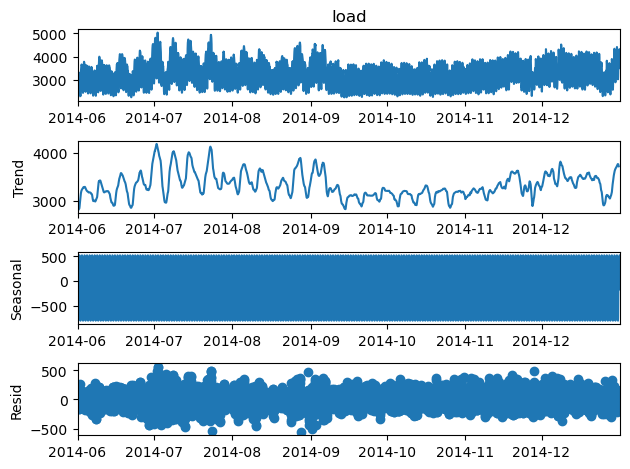

time: 1.3 s (started: 2023-05-04 11:41:00 +02:00)


In [38]:
#taking load column:
data_load = data['load']
#Calling our function:
decomposition = sm.tsa.seasonal_decompose(data_load['2014-06-01':'2014-12-31'], model = 'additive')
#Plotting:
fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

we can see that the seasonality is following a consistent pattern while the trend is following an irregular
behaviour for the second half of year 2014. 

We can also plot the trend alongside the observed load variations together:

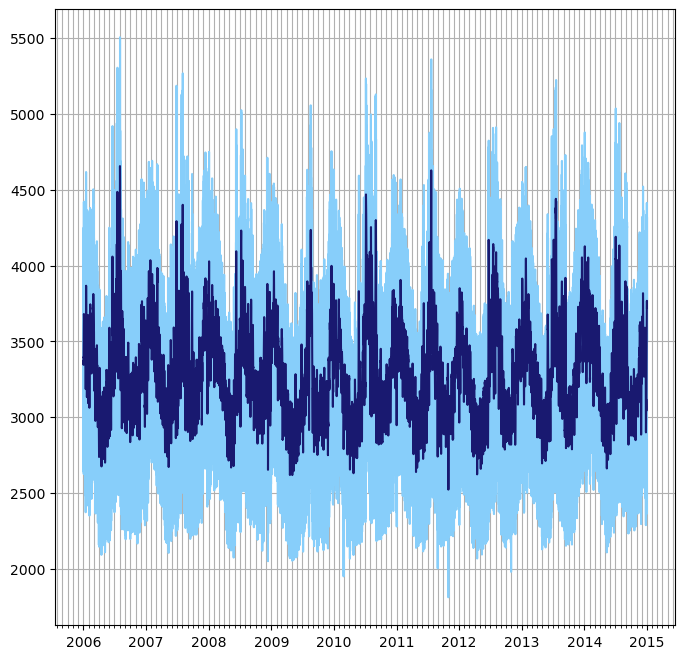

time: 1.83 s (started: 2023-05-04 11:41:01 +02:00)


In [39]:
#Calling function:
decomposition = sm.tsa.seasonal_decompose(data_load, model = 'additive')
#Plotting:
fig, ax = plt.subplots()
ax.grid(True)
#Matplotlib’s YearLocator() makes ticks on a given day of each year that is a multiple of base:
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(data_load.index, data_load, c=colors['lightskyblue'])
plt.plot(decomposition.trend.index, decomposition.trend, c=colors['midnightblue'])
mpl.rcParams['figure.figsize'] = [18.0, 6.0]

### Handling Missing Data

We have checked that the data has no missing elements, in neither load nor temperature. 

In general, missing values are represented in the time series by a sequence gap in the time stamp variable or in other values. If you have such a problem in your data, you
can fill missing values by interpolating between the two closest non-missing values via `dataframe.interpolate()`. However, you should note that only `method = 'linear'` is supported for DataFrames and series with a MultiIndex:

```
#you can interpolate linearly as follows:
data.interpolate(limit = 8, method ='linear', limit_direction ='both')
```

Note that if there is more than 8 missing data in both direction in time consecutively, the missing
values are not interpolated and they remain missing. This is set via `limit`. This is a precaution to limit the spurious interpolation.

You can also use `scipy.stats` package for more advanced options:

https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

### Normalization / Standardization in Time Series

Normalization rescales the data such that all values are within the range of 0 and 1. Standardization, on the other hand, rerescales the distribution of values so that
the mean values are 0 with a SD of 1. Similar to the previous exercises, we can use scikit learn for that purpose.

In [40]:
#Looking into the statistics:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 31 ms (started: 2023-05-04 11:41:03 +02:00)


In [41]:
#Rescaling the data
featuresToScale = data.columns
sX = pp.StandardScaler(copy=True)
data.loc[:,featuresToScale] = sX.fit_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,7.888800e+04,7.888800e+04
mean,3.127224e-16,8.646702e-17
std,1.000006e+00,1.000006e+00
min,-2.581929e+00,-3.415097e+00
25%,-7.985536e-01,-7.761984e-01
50%,1.276289e-01,5.708323e-02
75%,6.916171e-01,8.033911e-01
max,3.790965e+00,2.574114e+00


time: 63 ms (started: 2023-05-04 11:41:03 +02:00)


In [42]:
data.loc[:,featuresToScale] = sX.inverse_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 31 ms (started: 2023-05-04 11:41:04 +02:00)


## Feature Engineering in Time Series

Feature engineering enables you to optimize the data fed into the ML algorithms so that the predictive accuracy of the model increases. In time series, there are some well-known tricks which help to improve the model outcomes. Below you will find some illustrative examples for you to explore.

### Date - Time Features

Depending on the problem, you might see some patterns on sub-time items present in the time stamps; such as the hour, day, month etc. Imagine that you would like to capture the rush hour effects on utility consumption. In this case, it would be better to add this time information as an additional feature (column in dataframe). For that purpose, you can use `pandas` to add new columns (hour, month, and day of week columns) to your original dataset. In the ML algorithm, this new column will be taken into account as a new factor. 

Other important features might be:
+ Weekend or not
+ Business day or not
+ Public holiday or not
+ Quarter of the year
+ Before or after business hours
+ Season of the year

You can craft different filters according to your problem and your objective. 

In [43]:
data.head()

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00


time: 0 ns (started: 2023-05-04 11:41:04 +02:00)


In [44]:
#A simple example:
data['hour'] = [data.index[i].hour for i in range(len(data))]
data['month'] = [data.index[i].month for i in range(len(data))]
data['dayofWeek'] = [data.index[i].day for i in range(len(data))]
print(data.head(5))

                       load      T  hour  month  dayofWeek
2006-01-01 00:00:00  2985.0  24.33     0      1          1
2006-01-01 01:00:00  3010.0  22.67     1      1          1
2006-01-01 02:00:00  2853.0  20.67     2      1          1
2006-01-01 03:00:00  2758.0  21.33     3      1          1
2006-01-01 04:00:00  2705.0  19.00     4      1          1
time: 1.77 s (started: 2023-05-04 11:41:04 +02:00)


### Window Statistics as Feature

Another common trick is to introduce windows statistics as an additional feature. 

Sliding window method are a summary of values over a fixed window of prior timesteps. Here the basic idea is that you assume the past contain a sort of intrinsic information about the future that can be captured if you oberve the past in "windows".  A window of specified length is moved over the data, sample by sample, and the statistic of interest (mean, median etc) is computed over the data in these windows. For more, you may refer to:

https://www.geeksforgeeks.org/window-sliding-technique/

https://de.mathworks.com/help/dsp/ug/sliding-window-method-and-exponential-weighting-method.html

Here I will show you how to add "Rolling Window Statistics" as an additional feature to your data. 

In this method, you first define a rolling window of observations. Then, you use observations falling under this window to compute statistics of interest. Next, you roll over the next time step and repeat the same computation. You may consider it as an integral action over a given time interval.

`pandas` offers a `rolling()` function for that purpose, where it creates a new data structure with the window of values at each timestep:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

Here we will also a need the shifting in the time stamps. The shift method
uses a freq argument which can be a DateOffset class or a timedelta-like object or also an offset alias. 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

String aliases that are useful for common time series frequencies are listed here:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [45]:
#How to add statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Shifting:if needed, use shifted with .rolling.
#shifted = load_data.shift(2)
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.min(),window.median(), window.max(), load_data], axis=1)
new_dataframe.columns = ['min', 'median', 'max', 'load']
print(new_dataframe.head(10))

                        min  median     max    load
2006-01-01 00:00:00     NaN     NaN     NaN  2985.0
2006-01-01 01:00:00     NaN     NaN     NaN  3010.0
2006-01-01 02:00:00     NaN     NaN     NaN  2853.0
2006-01-01 03:00:00  2758.0  2919.0  3010.0  2758.0
2006-01-01 04:00:00  2705.0  2805.5  3010.0  2705.0
2006-01-01 05:00:00  2705.0  2733.5  2853.0  2709.0
2006-01-01 06:00:00  2705.0  2731.0  2758.0  2753.0
2006-01-01 07:00:00  2705.0  2731.0  2849.0  2849.0
2006-01-01 08:00:00  2709.0  2801.0  3008.0  3008.0
2006-01-01 09:00:00  2753.0  2928.5  3243.0  3243.0
time: 63 ms (started: 2023-05-04 11:41:06 +02:00)


It is also possible to use Expanding Window Statistics in `pandas`, where all past is taken into account. It is done via `expanding() `function. It's use is very similar to rolling:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.expanding.html

Feel free to test it by yourself!

# Some Basic Solutions for Time Series

This section is for you to explore. It is always to be aware of simple solutions, before jumping into more complex models. Speaking of which, I recommend to watch the following lecture on model simplicity:
[Winning with Simple, even Linear, Models](https://www.youtube.com/watch?v=68ABAU_V8qI). 

Linear statistical models (Autoregressive (AR) models, moving average (MA) models, and autoregressive integrated moving average (ARIMA) models) for time series have traditionally been the workhorses of time series forecasting, and they continue to be applied in a wide range of cases, from academic research to industry. This section will help you to have an idea on the subject. Note that these models are not built to handle nonlinear dynamics and will do a poor job describing data where nonlinear relationships are dominant.

## Autoregression

This is the simplest method: you assume that future depends on past linearly. 

In this model, one parameter is the "order", which defines the the number of previous input values in the time series that are used to predict the next step. Therefore, this is a hyperparameter to figure out for your data. 




### Autocorrelation

Because of this assumed linearity, autocorrelation becomes of significant importance here. It is a statistical property that occurs when a time series is linearly related to a previous time. 

In order to check whether there is a presence of autocorrelation in your data, you can use two different built-in plots of `pandas`: `lag_plot` and  `autocorrelation_plot`.  These functions can be imported from pandas.plotting:

https://pandas.pydata.org/docs/reference/api/pandas.plotting.lag_plot.html

https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html

Lag plots are most commonly used to look for patterns in time series data. For example, random data should not exhibit any patterns in the lag plot. Lets see our load data:

In [46]:
data.head()

,load,T,hour,month,dayofWeek
2006-01-01 00:00:00,2985.0,24.33,0,1,1
2006-01-01 01:00:00,3010.0,22.67,1,1,1
2006-01-01 02:00:00,2853.0,20.67,2,1,1
2006-01-01 03:00:00,2758.0,21.33,3,1,1
2006-01-01 04:00:00,2705.0,19.00,4,1,1


time: 0 ns (started: 2023-05-04 11:41:06 +02:00)


In [47]:
# Returning back to the original DF:
data = data.drop(['hour','month','dayofWeek'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2006-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    78888 non-null  float64
 1   T       78888 non-null  float64
dtypes: float64(2)
memory usage: 3.8 MB
time: 15 ms (started: 2023-05-04 11:41:07 +02:00)


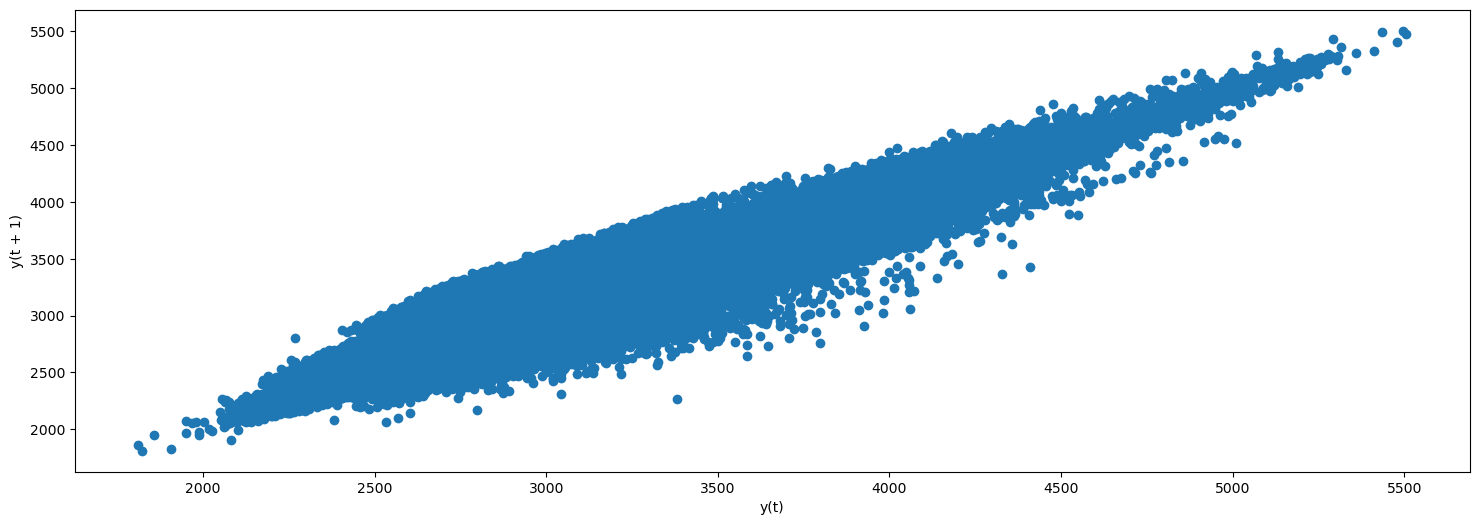

time: 734 ms (started: 2023-05-04 11:41:07 +02:00)


In [48]:
# Plotting the figure:
plt.figure()
lag_plot(data['load'])
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

Here we see a clear relationship between the time steps t and t+1. 

Autocorrelation plots are also useful to check the randomness in time series. If time series is random, autocorrelation values should be near zero all the time. Otherwise, the autocorrelations will be significantly non-zero. 

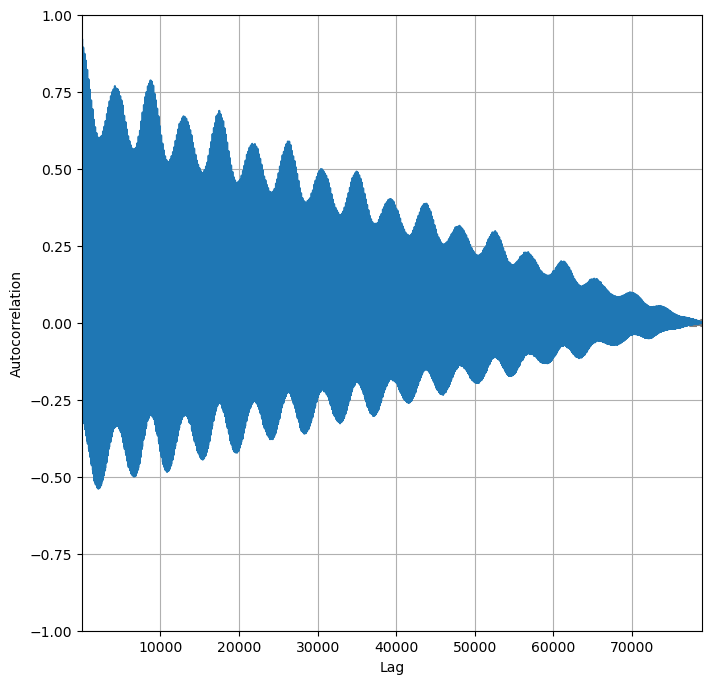

time: 6 s (started: 2023-05-04 11:41:08 +02:00)


In [49]:
#Checking autocorrelations:
plt.figure()
autocorrelation_plot(data['load'])
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

Let's zoom in into a fraction of the data:

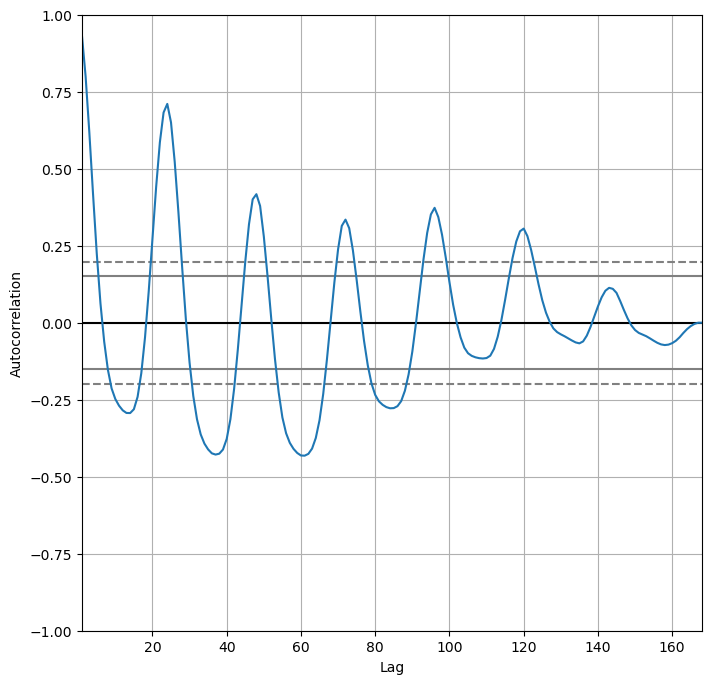

time: 296 ms (started: 2023-05-04 11:41:14 +02:00)


In [50]:
data_subset = data['load']['2014-01-01':'2014-01-07']
autocorrelation_plot(data_subset)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

Autocorrelation function ranges from –1 to 1. By default, the horizontal lines correspond to 95 percent  and the dashed line is 99 percent confidence band. Correlation values outside of this window are very likely a correlation. 

This plot tells us whether the data is positively correlated, negatively correlated, or independent of each other.

<Figure size 1200x600 with 0 Axes>

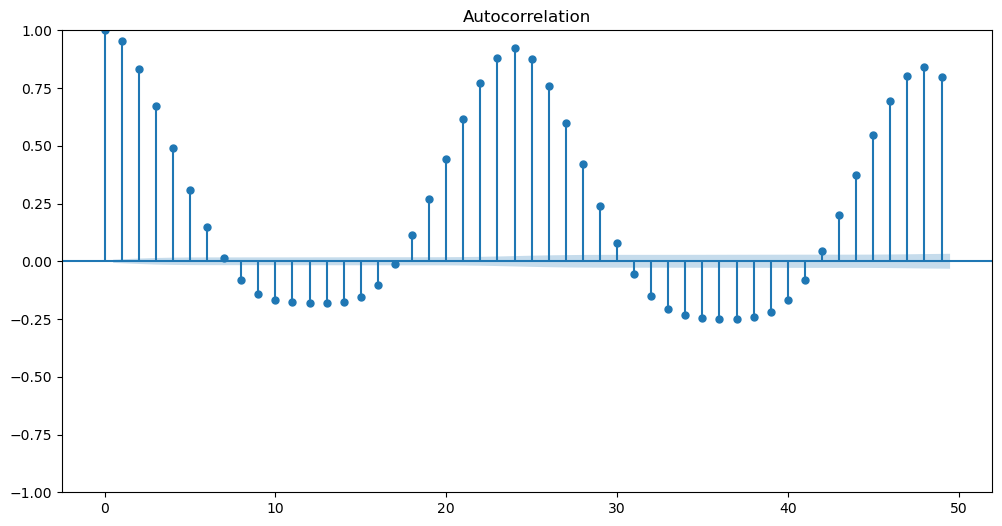

time: 10.4 s (started: 2023-05-04 11:41:14 +02:00)


In [51]:
#Another Library.
#Here confidence intervals are drawn as a cone:
plt.figure()
plot_acf(data['load']);

Another important concept to consider is partial correlation function (`pacf`). It is a function that measures the incremental benefit of adding another lag. Let's use it on our data:

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


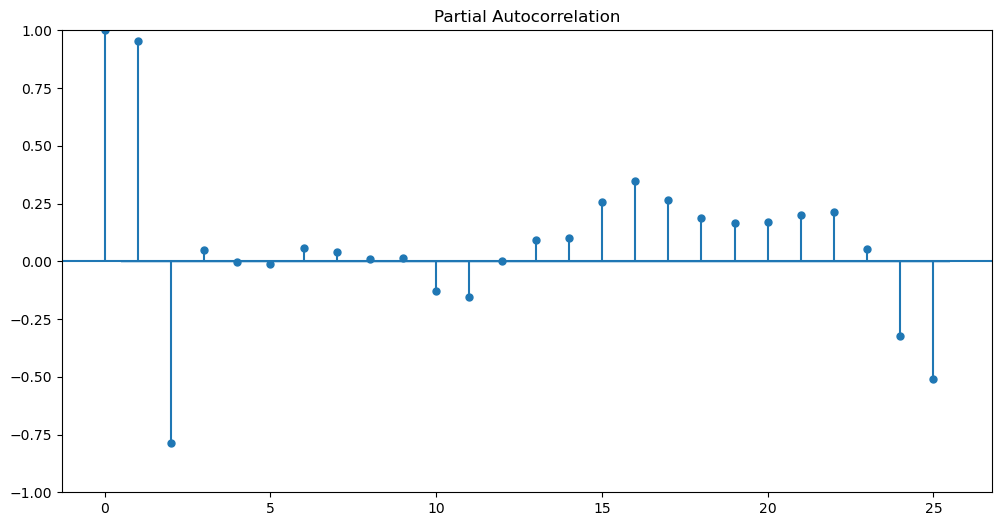

time: 360 ms (started: 2023-05-04 11:41:25 +02:00)


In [52]:
plot_pacf(data['load'], lags=25)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

Why do we need `acf` or `pacf`? We will use it to determine the
order of autoregressive and moving average time series methods. 

### Implementing the Model
If you examine the `acf` plot above, you will see that we have good positive correlation with the lags up to lag number 7 (until we hit the upper confidence threshold). However, if you check `pacf` plot, you would see that there is little benefit after the 4th lag (see multicollinearity problem for details). This will be the order of our autoregression model. In principle, the more lag variables you include in your model, the better the model will fit the data. Yet this will bring the risk of overfitting (memorizing the data). 

In this section, we will use an extended version of classic ARIMA. 

As a side note, ARIMA indicates three steps: 
+ autoregression (AR)
+ integration (I)
+ moving average (MA)

In this exercise we will use SARIMAX: 
+ seasonal (S)
+ autoregressive (AR)
+ integrated (I)
+ moving average (MA)
+ with exogenous factors (X).

This model is useful when you have to deal with time series that have seasonal cycles (which we suspect to have based on above analysis). The model postulates that the seasonal behavior itself can be thought of as an ARIMA
process:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarimax#statsmodels.tsa.statespace.sarimax.SARIMAX

In [53]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
# trainin data: filtered copy
train = data.copy()[(data.index >= train_start_dt)& (data.index < test_start_dt)][['load']]
# test data: filtered copy
test = data.copy()[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (18984, 1)
Test data shape:  (72, 1)
time: 16 ms (started: 2023-05-04 11:41:34 +02:00)


In [54]:
#Rescaling the data [0,1]
scaler = pp.MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)

time: 16 ms (started: 2023-05-04 11:41:37 +02:00)


In [56]:
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
order = (3, 1, 6)
#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.
seasonal_order = (1, 1, 1, 24) # 24 is the daily seasonality order

time: 0 ns (started: 2023-05-04 11:43:39 +02:00)


In [57]:
#Model implementation
#here endog is the observed time-series process y:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)

time: 16 ms (started: 2023-05-04 11:44:01 +02:00)


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


We will now perform the walk forward validation:

+ Step 1: at the beginning,  train the model on the train
data set

+ Step 2: make a prediction on the next time step. 

+ Step 3: the training set is  expanded to include the new known value, and the process is repeated. 

To keep the training set window fixed, every time we add
a new observation to the training set, we remove the observation from the beginning of the set.

In [58]:
#Copying the test DF:
test_shifted = test.copy()
#preparing the shifted test data:
for t in range(1, horizon):
  test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
test_shifted = test_shifted.dropna()
test_shifted

,load,load+1,load+2,load+3,load+4,load+5
2014-11-01 00:00:00,0.223112,0.164869,0.140216,0.126656,0.124191,0.135593
2014-11-01 01:00:00,0.164869,0.140216,0.126656,0.124191,0.135593,0.166718
2014-11-01 02:00:00,0.140216,0.126656,0.124191,0.135593,0.166718,0.226502
2014-11-01 03:00:00,0.126656,0.124191,0.135593,0.166718,0.226502,0.305393
2014-11-01 04:00:00,0.124191,0.135593,0.166718,0.226502,0.305393,0.372881
...,...,...,...,...,...,...
2014-11-03 14:00:00,0.430817,0.427427,0.448382,0.502311,0.585824,0.575655
2014-11-03 15:00:00,0.427427,0.448382,0.502311,0.585824,0.575655,0.539599
2014-11-03 16:00:00,0.448382,0.502311,0.585824,0.575655,0.539599,0.490601
2014-11-03 17:00:00,0.502311,0.585824,0.575655,0.539599,0.490601,0.396302


time: 32 ms (started: 2023-05-04 11:48:10 +02:00)


In [59]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2023-05-04 11:48:34 +02:00)


In [60]:
# Predictions on test data:
training_window = 720 # Here we are using a very small portion of the past,
# I think we made like this so that the trining is not too computationaly expensive
train_ts = train['load']
test_ts = test_shifted
#Creating the history
history = [x for x in train_ts]
#Filtering the training window: Uncomment the below line if you want.
history = history[(-training_window):]
#Creating predictions to store the model outcomes:
predictions = list()
#Calling model: 
#Horizon calculation list:
for t in range(0,test_ts.shape[0],horizon):
  model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
  #Model fitting:
  model_fit = model.fit()
  #Model predictions:
  y_p = model_fit.forecast(steps = horizon) # its like model predict in scikit learn
  obs = list(test_ts.iloc[t])
# moving the training window: here I add the prediction as in real life we would 
# not know the true value! Here we will also save the predictions.
  for j in range(horizon):
    predictions.append(y_p[j])
    history.append(y_p[j])
  #Dropping the first horizon elements:
  for j in range(horizon):
    history.pop(0)
  print(test_ts.index[t])
  print(t+1, ': predicted =', y_p, 'true value =', obs)

2014-11-01 00:00:00
1 : predicted = [0.20690915 0.16505007 0.12908577 0.10500978 0.10282806 0.1291246 ] true value = [0.22311248073959933, 0.16486902927580893, 0.1402157164869029, 0.12665639445300458, 0.12419106317411399, 0.13559322033898302]
2014-11-01 06:00:00
7 : predicted = [0.20609599 0.33836585 0.41076488 0.43033027 0.43975606 0.43954215] true value = [0.1667180277349769, 0.22650231124807396, 0.30539291217257314, 0.3728813559322034, 0.42434514637904464, 0.4489984591679508]
2014-11-01 12:00:00
13 : predicted = [0.43226497 0.41959069 0.41205159 0.39739926 0.39591992 0.4136722 ] true value = [0.4576271186440677, 0.4499229583975346, 0.44006163328197223, 0.4345146379044684, 0.43852080123266557, 0.4656394453004622]
2014-11-01 18:00:00
19 : predicted = [0.44947475 0.48145565 0.45857694 0.42091622 0.35185564 0.26453068] true value = [0.5044684129429893, 0.5109399075500771, 0.46995377503852076, 0.43050847457627106, 0.3679506933744222, 0.2933744221879815]
2014-11-02 00:00:00
25 : predicted

In [61]:
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
#Updating the indices:
eval_df=(eval_df.set_index(test.index)) #
#Adding true values:
eval_df['actual'] = test['load']
#Let's check:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-11-01 00:00:00 to 2014-11-03 23:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 15 ms (started: 2023-05-04 12:01:44 +02:00)


In [62]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

time: 0 ns (started: 2023-05-04 12:01:48 +02:00)


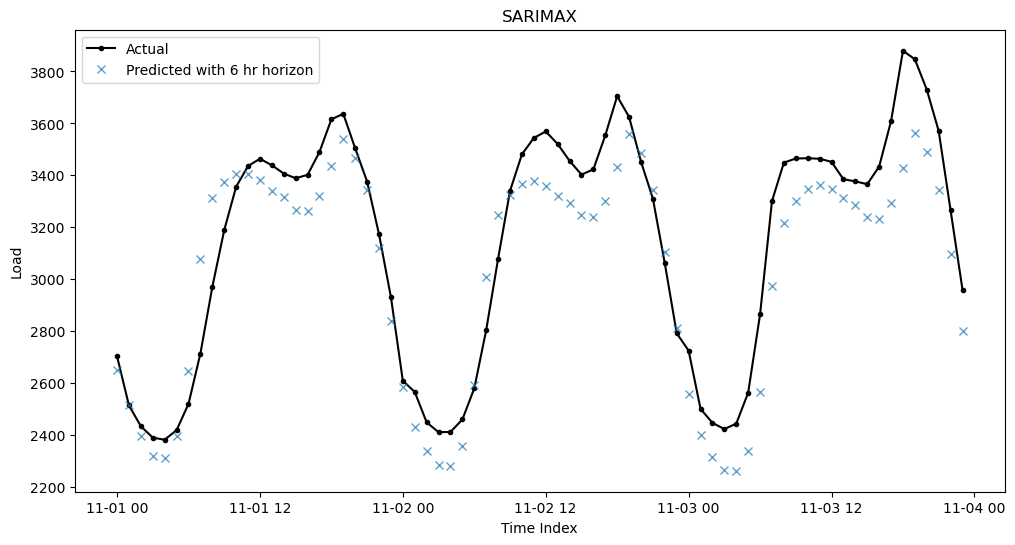

time: 453 ms (started: 2023-05-04 12:01:53 +02:00)


In [63]:
#Plotting predictions: 
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['prediction'], 'x', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[69:138], 'o', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[-69:], '+', alpha=0.70);
plt.legend(['Actual',
            ('Predicted with ' + str (horizon) + ' hr horizon')])
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SARIMAX');


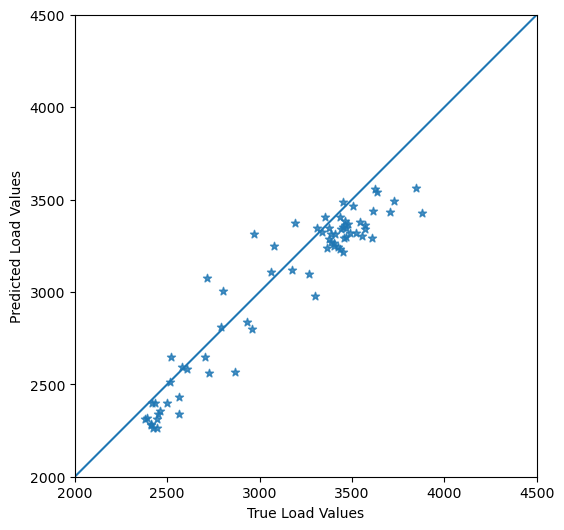

time: 250 ms (started: 2023-05-04 12:02:00 +02:00)


In [64]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['prediction'],marker='*',alpha=0.80)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[69:138],marker='o',alpha=0.60)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[138:207],marker='+',alpha=0.50)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [2000, 4500]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

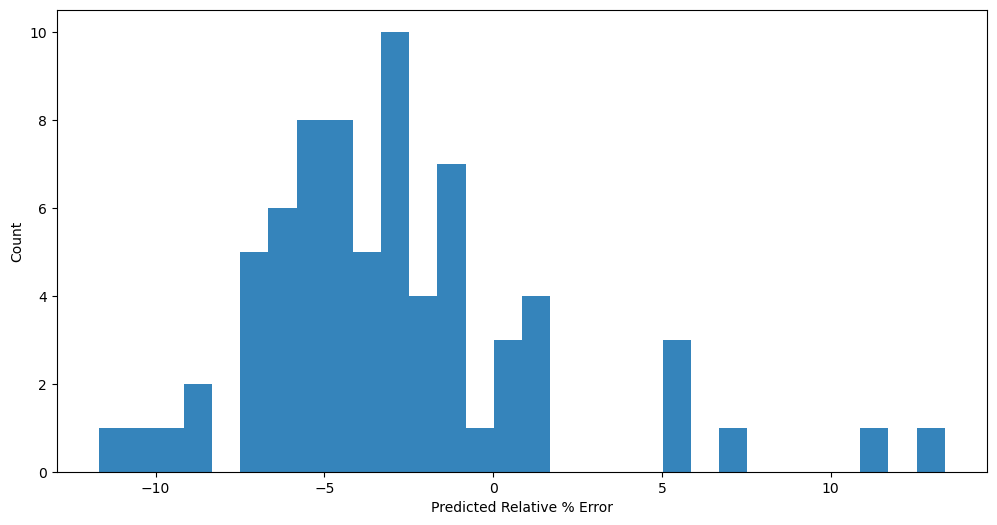

time: 296 ms (started: 2023-05-04 12:02:04 +02:00)


In [65]:
# Calculating the error variations:
error_nn1 = (eval_df['prediction'] - eval_df['actual'])/eval_df['actual']*100

plt.hist(error_nn1, bins=30,alpha=0.9)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [66]:
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  0.86
time: 0 ns (started: 2023-05-04 12:02:08 +02:00)


# ML Algorithms for Forecasting: SVM

## Organizing the Feature Matrix

In [67]:
#Checking Data:
data.sample(3)

,load,T
2013-08-15 09:00:00,3490.0,58.67
2007-06-16 03:00:00,2388.0,54.67
2008-12-15 18:00:00,4003.0,54.67


time: 47 ms (started: 2023-05-04 13:50:33 +02:00)


In [68]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 109 ms (started: 2023-05-04 13:50:38 +02:00)


In [69]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.88271,21.33,2758.0


time: 15 ms (started: 2023-05-04 13:50:42 +02:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

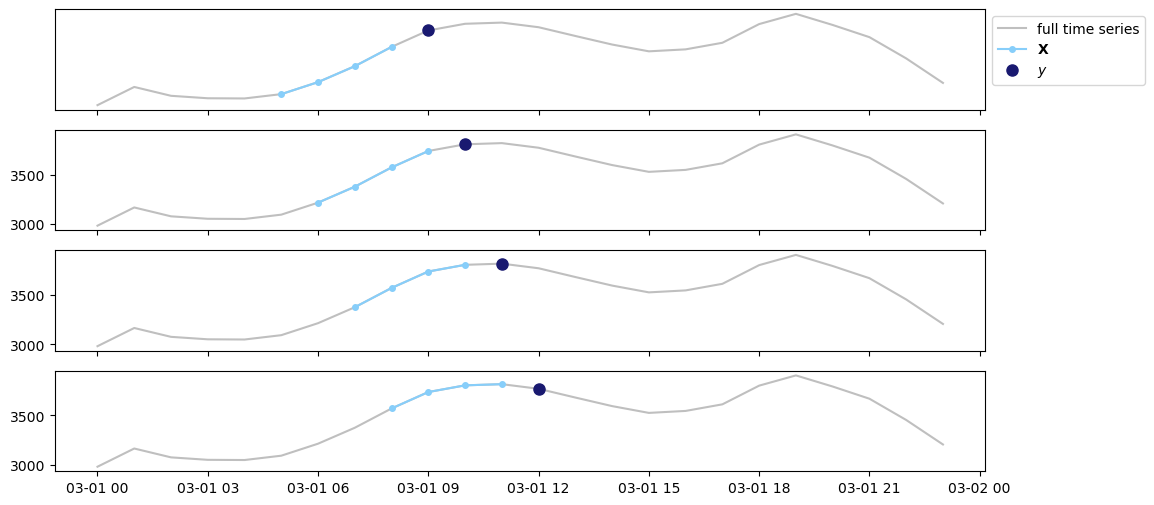

time: 2.11 s (started: 2023-05-04 13:52:38 +02:00)


In [70]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create our feature matrix A in this way.

In [71]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 4
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 2.66 s (started: 2023-05-04 13:52:58 +02:00)


#### Example:

    Sure, let me explain this part of the code with an example. The purpose of this loop is to create sliding windows of data for the features (dataX) and the target variable (dataY).

    Let's say our new_dataframe looks like this (a simple example with 7 rows and 4 columns, including the target variable 'load'):

new_dataframe:
|    Date    | median_t | std_t | T_t | load |
|------------|----------|-------|-----|------|
| 2012-09-01 |        1 |     5 |   9 |   13 |
| 2012-09-02 |        2 |     6 |  10 |   14 |
| 2012-09-03 |        3 |     7 |  11 |   15 |
| 2012-09-04 |        4 |     8 |  12 |   16 |
| 2012-09-05 |        5 |     9 |  13 |   17 |
| 2012-09-06 |        6 |    10 |  14 |   18 |
| 2012-09-07 |        7 |    11 |  15 |   19 |

    And we set window = 3.

    Now, let's walk through the loop:

    i = start (i.e., the index of the first row)

    We create a window of size 3 for features:

    Copy code
    1  5  9
    2  6 10
    3  7 11
    We ravel this window into a single row:

    Copy code
    1  5  9  2  6 10  3  7 11
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 16) and add it to dataY.

    i = start + 1 (i.e., the index of the second row)

    We create a window of size 3 for features:

    Copy code
    2  6 10
    3  7 11
    4  8 12
    We ravel this window into a single row:

    Copy code
    2  6 10  3  7 11  4  8 12
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 17) and add it to dataY.

    The loop continues until i = end - window. After the loop, dataX and dataY will look like this:

    yaml
    Copy code
dataX:
|    Date    | median_t_1 | std_t_1 | T_t_1 | median_t_2 | std_t_2 | T_t_2 | median_t_3 | std_t_3 | T_t_3 |
|------------|------------|---------|-------|------------|---------|-------|------------|---------|-------|
| 2012-09-04 |          1 |       5 |     9 |          2 |       6 |    10 |          3 |       7 |    11 |
| 2012-09-05 |          2 |       6 |    10 |          3 |       7 |    11 |          4 |       8 |    12 |

dataY:
|    Date    | load |
|------------|------|
| 2012-09-04 |   16 |
| 2012-09-05 |   17 |

    In this example, we have created a dataset with sliding windows of size 3, where each row in dataX contains the features from a window and the corresponding row in dataY contains the target variable ('load') right after that window.

    Increasing the value of the sliding window changes the amount of historical data being considered for each instance in the dataset. A larger sliding window size means that more past data points are being used to predict the target variable.

    In the context of your example, increasing the sliding window size to 48 would mean that each instance in dataX would have information from the 48 previous time steps. The physical meaning of this change depends on the temporal resolution of your data. For example, if your data is hourly, a sliding window of 48 would consider the past 48 hours of data for each prediction, while if the data is daily, it would consider the past 48 days.

    A larger sliding window size may capture longer-term patterns in the data, making it potentially more useful for predicting the target variable. However, it's important to note that increasing the sliding window size also increases the dimensionality of the input features, which can lead to a more complex model and may require more computational resources. Additionally, a larger window size may result in less training instances, as more data is required to form each instance.

    Ultimately, the optimal sliding window size depends on the specific problem and the nature of the data. It may be useful to experiment with different window sizes and evaluate the performance of the resulting models to find the best trade-off between capturing meaningful patterns in the data and maintaining a manageable input feature size.

In [72]:
#Original DF:
new_dataframe.loc['2014-09-01 00:00:00':'2014-09-04 00:00:00'].head(6)

,median,std,T,load
2014-09-01 00:00:00,3504.0,339.155815,69.67,3087.0
2014-09-01 01:00:00,3226.0,329.974115,71.00,2886.0
2014-09-01 02:00:00,2986.5,261.282095,70.00,2768.0
2014-09-01 03:00:00,2827.0,169.892123,69.33,2699.0
2014-09-01 04:00:00,2733.5,92.903175,68.33,2681.0
2014-09-01 05:00:00,2694.5,39.686270,68.33,2690.0


time: 15 ms (started: 2023-05-04 13:54:30 +02:00)


In [73]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
2012-09-01 04:00:00,3543.0,524.914199,59.33,2719.0,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0,2622.0,123.494939,67.67,2537.0


time: 16 ms (started: 2023-05-04 13:54:34 +02:00)


In [80]:
dataX.shape

(19052, 16)

time: 16 ms (started: 2023-05-04 14:04:52 +02:00)


In [74]:
dataY.head(2)

2012-09-01 04:00:00    2537.0
2012-09-01 05:00:00    2525.0
dtype: float64

time: 0 ns (started: 2023-05-04 13:54:36 +02:00)


In [81]:
dataY.shape

(19052,)

time: 0 ns (started: 2023-05-04 14:05:04 +02:00)


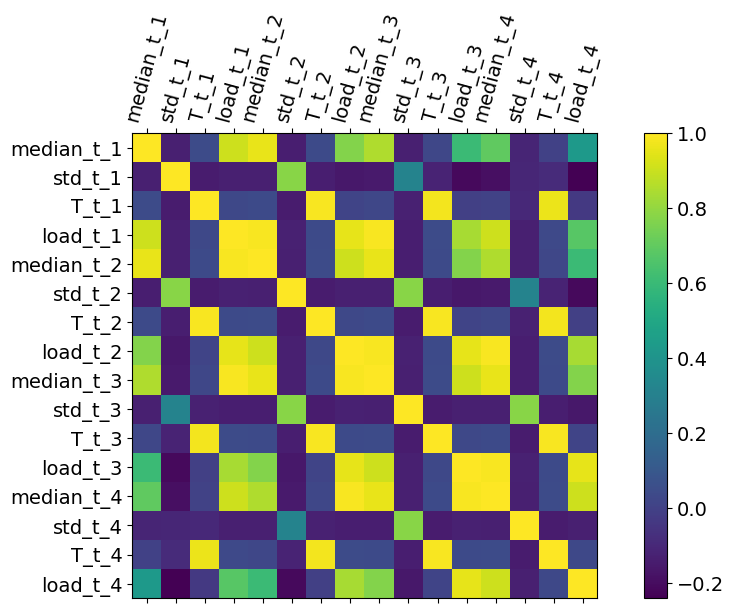

time: 625 ms (started: 2023-05-04 13:54:54 +02:00)


In [75]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [76]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
count,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04
mean,2.386875e-16,-7.160624e-17,-3.329690e-15,-2.923921e-16,2.028843e-16,-2.301096e-16,-3.544509e-15,9.845858e-17,-2.237695e-16,-3.136502e-16,-3.520640e-15,-2.028843e-16,-1.670812e-16,-2.465194e-16,-3.580312e-15,4.057687e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.356536e+00,-1.250854e+00,-3.150932e+00,-2.363943e+00,-2.356523e+00,-1.250961e+00,-3.150906e+00,-2.364070e+00,-2.356548e+00,-1.251018e+00,-3.150913e+00,-2.364173e+00,-2.356666e+00,-1.251030e+00,-3.150905e+00,-2.364310e+00
25%,-7.726966e-01,-8.791492e-01,-7.639865e-01,-7.721103e-01,-7.727081e-01,-8.791741e-01,-7.639432e-01,-7.722154e-01,-7.727602e-01,-8.791741e-01,-7.638814e-01,-7.722968e-01,-7.721740e-01,-8.791720e-01,-7.638207e-01,-7.723794e-01
50%,1.141806e-01,-3.143736e-01,9.416024e-02,1.191733e-01,1.141554e-01,-3.142749e-01,9.420957e-02,1.190803e-01,1.140882e-01,-3.141876e-01,9.429610e-02,1.190114e-01,1.140057e-01,-3.141646e-01,9.437566e-02,1.189593e-01
75%,6.730222e-01,7.707527e-01,7.982938e-01,6.788994e-01,6.729884e-01,7.708772e-01,7.983482e-01,6.788141e-01,6.729117e-01,7.710807e-01,7.984550e-01,6.787530e-01,6.728372e-01,7.711371e-01,7.985500e-01,6.787200e-01
max,3.458144e+00,4.153972e+00,2.446595e+00,3.420488e+00,3.458067e+00,4.155047e+00,2.446661e+00,3.420440e+00,3.457943e+00,4.155826e+00,2.446815e+00,3.420417e+00,3.457908e+00,4.156014e+00,2.446946e+00,3.420478e+00


time: 125 ms (started: 2023-05-04 13:55:05 +02:00)


    dataX is a 2-dimensional data structure (a pandas DataFrame) that contains input features for the model. Each row in dataX represents a window of the time series data, containing information like median temperature, standard deviation of temperature, and load for each time step within the window. The columns of dataX are named accordingly (e.g., 'median_t_1', 'std_t_1', 'T_t_1', 'load_t_1').

    dataY is a 1-dimensional data structure (a pandas Series) that contains the target values, which are the load values for the time step immediately following each window in dataX. The purpose of dataY is to provide the true load values that the model should predict based on the input features in dataX.

    Physically, dataX and dataY are in-memory data structures that hold information from the original time series data in a format suitable for training and evaluating a machine learning model. They are constructed using a sliding window approach, extracting relevant features and target values from the time series data to facilitate prediction tasks.

In [84]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (18980, 16) (18980,)
Test data shape:  (72, 16) (72,)
time: 16 ms (started: 2023-05-04 14:09:39 +02:00)


## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [82]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2023-05-04 14:09:30 +02:00)


In [85]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 42.3 s (started: 2023-05-04 14:11:29 +02:00)


In [80]:
#Model Predictions:
#------------------
scoreTraining = model.score(X_train, y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9643835749087721
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9650015835372006
-----------------------------------
time: 8.9 s (started: 2022-12-20 15:08:05 +00:00)


In [81]:
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 44.4 ms (started: 2022-12-20 15:08:14 +00:00)


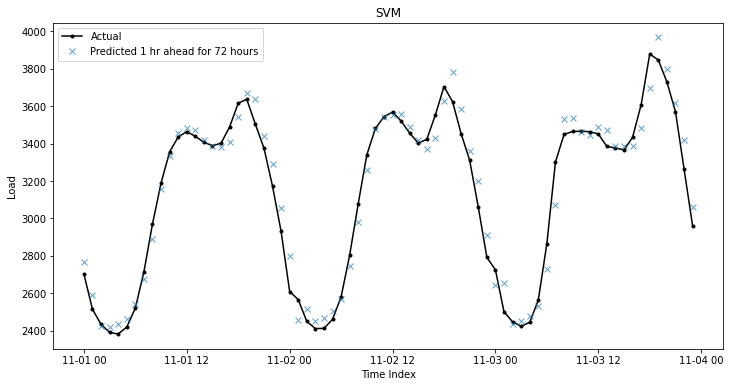

time: 265 ms (started: 2022-12-20 15:08:14 +00:00)


In [82]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

# ML Algorithms for Forecasting: SVM - II 

## Organizing the Feature Matrix

In [86]:
#Checking Data:
data.sample(3)

,load,T
2008-09-03 23:00:00,3226.0,64.33
2007-01-04 15:00:00,3605.0,48.00
2012-05-08 09:00:00,3277.0,50.67


time: 62 ms (started: 2023-05-04 17:10:06 +02:00)


In [87]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 141 ms (started: 2023-05-04 17:10:13 +02:00)


In [88]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 78 ms (started: 2023-05-04 17:10:16 +02:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

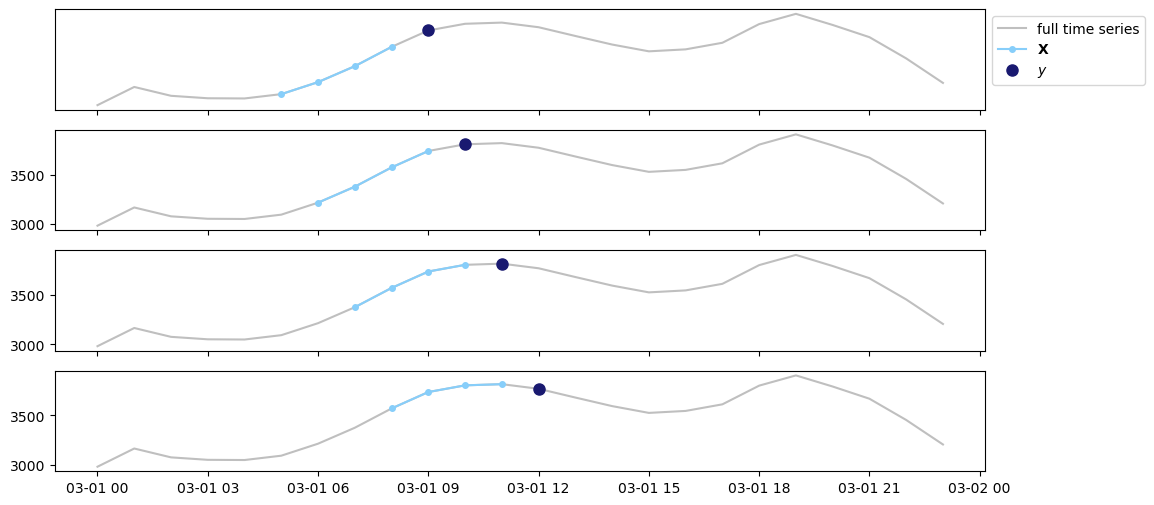

time: 1.78 s (started: 2023-05-04 17:10:55 +02:00)


In [89]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create our feature matrix A in this way.

In [90]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 3.42 s (started: 2023-05-04 17:11:00 +02:00)


In [91]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 32 ms (started: 2023-05-04 17:11:14 +02:00)


In [92]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 32 ms (started: 2023-05-04 17:11:30 +02:00)


In [93]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
dtype: float64

time: 0 ns (started: 2023-05-04 17:11:41 +02:00)


In [91]:
#Correlation Matrix
#correlationMatrix = pd.DataFrame(dataX).corr() 

#f = plt.figure(figsize=(12, 6))
#plt.matshow(correlationMatrix, fignum=f.number)
#plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
#plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.show()

time: 578 µs (started: 2022-12-20 15:08:17 +00:00)


In [94]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,2.613099e-14,-3.181892e-15,1.256010e-16,1.614870e-16,2.555083e-14,-3.576638e-15,-2.392400e-17,-1.256010e-16,2.665731e-14,...,-2.775184e-15,-2.721355e-16,-6.100619e-16,2.441444e-14,-3.050310e-15,-1.824205e-16,6.100619e-16,2.364289e-14,-2.954614e-15,-1.794300e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 1.33 s (started: 2023-05-04 17:11:48 +02:00)


In [95]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 203 ms (started: 2023-05-04 17:12:45 +02:00)


## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [96]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 0 ns (started: 2023-05-04 17:28:36 +02:00)


In [97]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 63 ms (started: 2023-05-04 17:28:41 +02:00)


In [98]:
#Model Predictions:
#------------------
#scoreTraining = model.score(X_train, y_train)
#print('-----------------------------------')
#print('SVM Regression Training R^2 Score: ', scoreTraining)
#print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Validation R^2 Score:  0.9235792821874824
-----------------------------------
time: 16 ms (started: 2023-05-04 17:28:52 +02:00)


In [99]:
#Visual Comparisons
#------------------
# Lets get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 16 ms (started: 2023-05-04 17:29:25 +02:00)


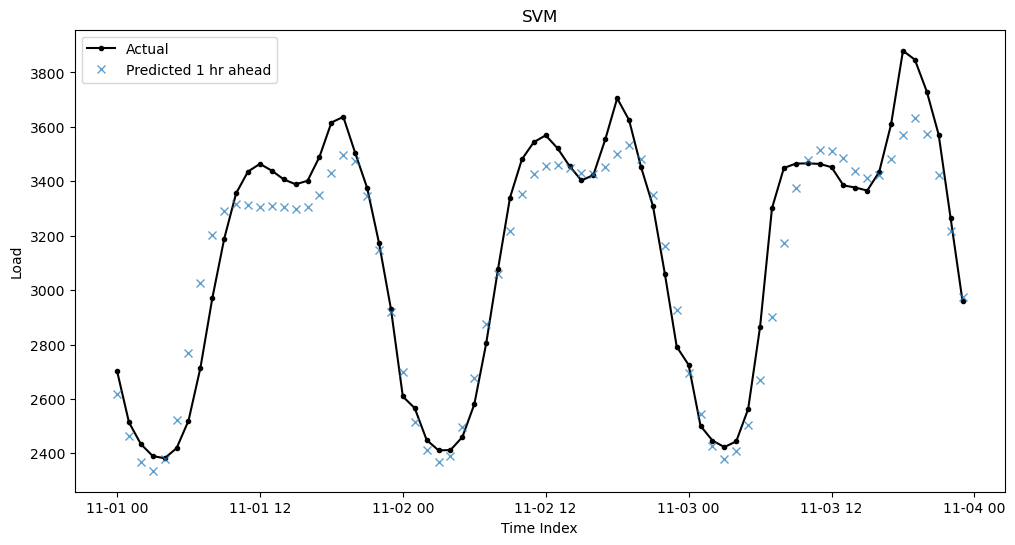

time: 360 ms (started: 2023-05-04 17:29:38 +02:00)


In [100]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Forecasting further in time...

Lets use the SVM to predict further horizons by just using the training wisdom. Here we will follow a similar anology. We need to update the passed information about the past as we progress. Here, it is a bit more difficult as we need to update the created features as well. Lets see how it can be implemented.


In this section, the goal is to use the Support Vector Machine (SVM) model to make predictions further into the future. This process is called forecasting.

To accomplish this, we need to iteratively update the past information as we progress in time, making predictions for future time steps. This is a more challenging task because we also need to update the features used in the model as we move forward.

The basic idea can be summarized in the following steps:

1. `Train the SVM model on the available historical data.`
2. `Make a prediction for the next time step using the trained model.`
3. `Update the historical data and features with the new prediction.`
4. `Go back to step 2, using the updated historical data and features to make a prediction for the next time step.`

By repeating these steps, we can forecast further into the future while incorporating the information from previous predictions.

The significance of this approach is that it allows us to make predictions beyond the available test data, leveraging the "wisdom" gained from training the model on historical data. This is particularly useful when trying to anticipate trends, make business decisions, or plan for future events based on past patterns.

-----------------------------------------------------------------------------------------------------------------------------
    Here's a simplified, visual example to help you understand how to use an SVM model for forecasting further horizons by updating the input features for each prediction.

    Let's consider a simplified dataset containing only 3 features and the target variable (load) over 5 time steps:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load |
|-----------|-----------|-----------|-----------|------|
| 1         | 1         | 5         | 9         | 13   |
| 2         | 2         | 6         | 10        | 14   |
| 3         | 3         | 7         | 11        | 15   |
| 4         | 4         | 8         | 12        | 16   |
| 5         | 5         | 9         | 13        | 17   |

    We can use a sliding window of size 2 for this example. The dataset would be transformed into the following format:

| Time step | Feature 1_t1 | Feature 2_t1 | Feature 3_t1 | Feature 1_t2 | Feature 2_t2 | Feature 3_t2 | Load |
|-----------|--------------|--------------|--------------|--------------|--------------|--------------|------|
| 3         | 1            | 5            | 9            | 2            | 6            | 10           | 15   |
| 4         | 2            | 6            | 10           | 3            | 7            | 11           | 16   |
| 5         | 3            | 7            | 11           | 4            | 8            | 12           | 17   |

    Now, we train an SVM model using the transformed dataset. To forecast further horizons, we follow these steps:

    1. Train the SVM model on the available historical data.
    2. Make a prediction for the next time step (Time step 6) using the trained model and the last window of features from the historical data (i.e., [3, 7, 11, 4, 8, 12]).
    3. Update the historical data and features with the new prediction. In this case, we would replace the oldest data point (Time step 1) with the new prediction and shift the remaining data points up by one time step. We would also update the features accordingly.
    4. Repeat steps 2-3 to make predictions for further time steps.

    Here's an example of how the historical data and features would be updated after making a prediction for Time step 6:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load    |
|-----------|-----------|-----------|-----------|---------|
| 2         | 2         | 6         | 10        | 14      |
| 3         | 3         | 7         | 11        | 15      |
| 4         | 4         | 8         | 12        | 16      |
| 5         | 5         | 9         | 13        | 17      |
| 6         | New_F1    | New_F2    | New_F3    | New_Load|

    By iteratively updating the historical data and features, we can forecast further into the future, leveraging the "wisdom" gained from training the model on historical data.

In [101]:
#Checking Data:
data.sample(3)

,load,T
2014-07-27 00:00:00,2956.0,67.00
2014-07-02 12:00:00,4879.0,83.33
2014-04-05 06:00:00,2720.0,37.00


time: 16 ms (started: 2023-05-04 17:34:00 +02:00)


In [102]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 78 ms (started: 2023-05-04 17:34:01 +02:00)


In [103]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2023-05-04 17:34:04 +02:00)


In [104]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-12-31 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 3.17 s (started: 2023-05-04 17:34:05 +02:00)


In [105]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 31 ms (started: 2023-05-04 17:34:09 +02:00)


In [106]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2023-05-04 17:34:12 +02:00)


In [107]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
dtype: float64

time: 16 ms (started: 2023-05-04 17:34:15 +02:00)


In [108]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,...,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04
mean,1.534348e-16,1.604649e-14,-3.559688e-15,1.115890e-16,-5.551551e-16,1.584563e-14,-3.715913e-15,2.050447e-16,2.901313e-16,1.744136e-14,...,-3.794025e-15,-2.915262e-16,-3.403463e-16,1.468511e-14,-3.626641e-15,-8.648145e-17,6.862721e-16,1.506451e-14,-3.648959e-15,3.849819e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-2.355880e+00,-2.958309e+00,-3.153453e+00,-2.385987e+00,-2.355820e+00,-2.958401e+00,-3.153275e+00,-2.386093e+00,-2.355760e+00,-2.958481e+00,...,-3.147893e+00,-2.387341e+00,-2.357287e+00,-2.959521e+00,-3.147675e+00,-2.387288e+00,-2.357430e+00,-2.959641e+00,-3.147327e+00,-2.387307e+00
25%,-6.224290e-01,-6.242725e-01,-7.685031e-01,-7.777970e-01,-6.223606e-01,-6.242466e-01,-7.683892e-01,-7.778604e-01,-6.222921e-01,-6.242185e-01,...,-7.635315e-01,-7.779760e-01,-6.222434e-01,-6.237019e-01,-7.633885e-01,-7.780103e-01,-6.223742e-01,-6.236980e-01,-7.632052e-01,-7.780655e-01
50%,-1.288194e-01,-9.989587e-02,3.205064e-02,1.232201e-01,-1.287485e-01,-9.984365e-02,3.214288e-02,1.231807e-01,-1.286777e-01,-9.979099e-02,...,3.682467e-02,1.226942e-01,-1.286535e-01,-1.004424e-01,3.694223e-02,1.226109e-01,-1.287808e-01,-1.004188e-01,3.707034e-02,1.225355e-01
75%,6.307080e-01,4.340683e-01,7.981382e-01,6.903942e-01,6.307825e-01,4.339395e-01,7.982098e-01,6.903700e-01,6.308570e-01,4.339409e-01,...,8.027232e-01,6.914441e-01,6.308434e-01,4.343817e-01,8.028165e-01,6.913299e-01,6.307215e-01,4.343356e-01,8.028917e-01,6.912417e-01
max,4.194005e+00,4.584623e+00,2.521444e+00,3.438317e+00,4.194096e+00,4.584911e+00,2.521469e+00,3.438366e+00,4.194188e+00,4.585182e+00,...,2.525603e+00,3.434720e+00,4.192336e+00,4.588446e+00,2.525642e+00,3.434457e+00,4.192239e+00,4.588490e+00,2.525598e+00,3.434307e+00


time: 1.09 s (started: 2023-05-04 17:34:22 +02:00)


In [119]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-03 00:00:00    0.658707
2012-09-03 01:00:00    1.198676
2012-09-03 02:00:00    1.076478
2012-09-03 03:00:00    1.180921
2012-09-03 04:00:00    1.094233
                         ...   
2014-12-30 19:00:00   -0.246289
2014-12-30 20:00:00   -0.281278
2014-12-30 21:00:00   -0.385720
2014-12-30 22:00:00   -0.472408
2014-12-30 23:00:00   -0.507396
Name: T_t_1, Length: 20376, dtype: float64

time: 16 ms (started: 2023-05-04 17:56:00 +02:00)


In [109]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 250 ms (started: 2023-05-04 17:42:21 +02:00)


In [110]:
# First element passed to SVM:
X_last = X_test.iloc[0:1]

time: 0 ns (started: 2023-05-04 17:42:26 +02:00)


In [111]:
X_last

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2014-11-01,-0.135467,0.127658,-0.298511,-1.066769,-0.135397,0.121461,0.06713,-1.443769,-0.135326,0.119772,...,-0.206467,0.009662,-0.668777,-0.994718,-0.189113,-0.300789,-0.668908,-0.972099,-0.293376,-0.745773


time: 31 ms (started: 2023-05-04 17:42:27 +02:00)


In [112]:
# Creating a list of last loads:
last_loads = list ()
s_window = 24
for i in range (1,s_window+1):
  column = 'load_t_'+ str (i)
  last_loads.append(X_last[column][0])
last_loads = np.array(last_loads)
last_loads

array([-1.06676868, -1.44376922, -1.59809716, -1.67346251, -1.65371422,
       -1.47603732, -0.99145552, -0.06890565,  0.37799529,  0.38691767,
        0.4066172 ,  0.32041933,  0.24858831,  0.15522374,  0.15340716,
        0.0959495 ,  0.07618368,  0.17128067,  0.44581801,  0.75796848,
        0.66272934,  0.4634543 ,  0.01481442, -0.58630536])

time: 0 ns (started: 2023-05-04 17:42:53 +02:00)


In [113]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test.index)

time: 0 ns (started: 2023-05-04 17:53:25 +02:00)


In [114]:
#import lib
from pandas.tseries.offsets import DateOffset

time: 0 ns (started: 2023-05-04 17:53:29 +02:00)


In [116]:
#Conversion:
X_test_last = X_last.to_numpy()
X_test_last.shape

(1, 192)

time: 0 ns (started: 2023-05-04 17:53:42 +02:00)


In [117]:
X_test_last

array([[-0.13546731,  0.12765831, -0.29851068, -1.06676868, -0.13539651,
         0.12146142,  0.06713026, -1.44376922, -0.13532571,  0.11977188,
        -0.01999049, -1.59809716, -0.13525491,  0.11427877, -0.12435371,
        -1.67346251, -0.13518411,  0.10609373, -0.1937283 , -1.65371422,
        -0.13511331,  0.09645576, -0.24587036, -1.47603732, -0.13504251,
         0.08734555, -0.31525035, -0.99145552, -0.13497171,  0.08990252,
        -0.33292245, -0.06890565, -0.09833772,  0.10109127, -0.40229381,
         0.37799529, -0.09827176,  0.10370958, -0.38497225,  0.38691767,
        -0.09821017,  0.10160344, -0.21044671,  0.4066172 , -0.13308568,
         0.07341006, -0.05367567,  0.32041933, -0.18792095,  0.04455861,
         0.15533126,  0.24858831, -0.20120424,  0.01180959,  0.24213534,
         0.15522374, -0.29925239, -0.02198351,  0.32947277,  0.15340716,
        -0.38734412, -0.04560535,  0.32959266,  0.0959495 , -0.44220897,
        -0.07167113,  0.38195809,  0.07618368, -0.4

time: 16 ms (started: 2023-05-04 17:53:48 +02:00)


In [120]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test.index
#n_features:
n_features = 4
#For scaling the predictions:
dummy_array = np.zeros((1,X_test_last.shape[1]))
for case_index in case_indices:
  #Predicting with fitted SVM and writing the result on y_predicted at the same time:
  load_prediction = svr.predict(X_test_last).flatten()[0]
  #print(load_prediction)
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,X_test_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,X_test_last.shape[1]-1]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
  #print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  min_i = np.min(last_loads)
  max_i = np.max(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #updating X_last:
  for i in range (X_test_last.shape[1]-n_features):
    X_test_last[0][i] =X_test_last[0][i+n_features]

  X_test_last[0][X_test_last.shape[1]-n_features+0] =median_i
  X_test_last[0][X_test_last.shape[1]-n_features+1] =std_i
#  X_test_last[0][X_test_last.shape[1]-n_features+2] =min_i
#  X_test_last[0][X_test_last.shape[1]-n_features+3] =max_i
  X_test_last[0][X_test_last.shape[1]-n_features+2] =temp_i
  X_test_last[0][X_test_last.shape[1]-n_features+3] =load_scaled


C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\

time: 313 ms (started: 2023-05-04 17:56:04 +02:00)


C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\rofer\AppData\Roam

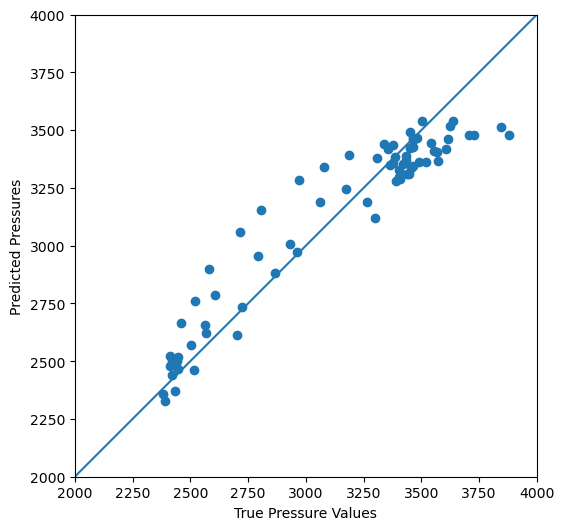

time: 297 ms (started: 2023-05-04 17:56:22 +02:00)


In [121]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predicted)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

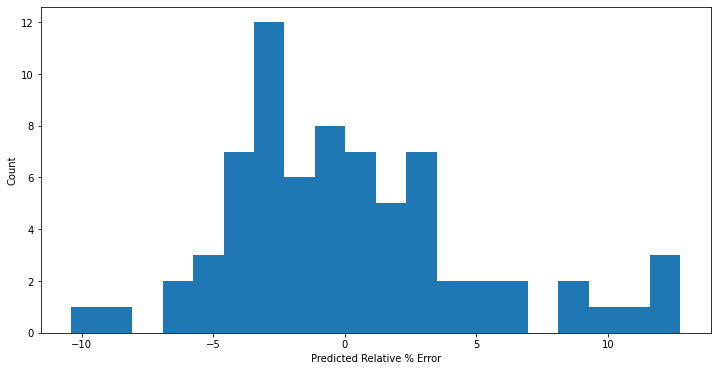

time: 224 ms (started: 2022-12-20 15:08:22 +00:00)


In [118]:
# Calculating the error variations:
error_nn = (y_predicted - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [119]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test)/y_test*100
np.average(error_nn)

0.20082137383612386

time: 35 ms (started: 2022-12-20 15:08:23 +00:00)


In [120]:
#Calculating R2 value:
r2_test = r2_score(y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89
time: 4.69 ms (started: 2022-12-20 15:08:23 +00:00)


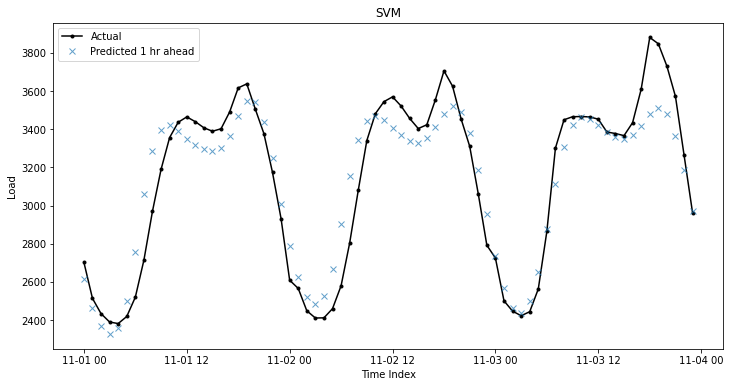

time: 274 ms (started: 2022-12-20 15:08:23 +00:00)


In [121]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

# Self Study

It would be a good exercise to combine SVM with PCA. 

i) Create a feature matrix X with a much larger sliding window. You may also add additional features.

ii) Transform and reduce the dimensionality via PCA (#_components should be high enough to cover >95% variance).

iii) Feed transformed X into SVM. 

iV) Try to predict much further points in time.



# Reading Material

https://en.wikipedia.org/wiki/Time_series

https://earthobservatory.nasa.gov/features/WxForecasting

https://robjhyndman.com/hyndsight/forecasting-competitions/

https://en.wikipedia.org/wiki/Autocorrelation

https://en.wikipedia.org/wiki/Partial_autocorrelation_function

Dataset source: Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, 2016.

https://www.ge.com/power/future-of-energy

https://www.ge.com/news/reports/part-1-transformation-change-energy-ecosystem

# Predict much further points in time

    To forecast more than 1 hour ahead, you can modify the loop to predict multiple hours ahead instead of updating the input features at each step. You can do this by changing the loop's structure to forecast a specified number of hours ahead (n_hours_ahead) and then updating the input features once every n_hours_ahead iterations.

    Here's a modification to the code to achieve this:

    1. Define the number of hours ahead you want to forecast, e.g., n_hours_ahead = 3 (3 hours ahead).
    2. Modify the loop to predict n_hours_ahead hours ahead at each step.
    3. Update the input features once every n_hours_ahead iterations.
    
    Please note that this approach assumes you have access to the required weather forecast data for the additional hours ahead.

In [ ]:
# Define the number of hours ahead you want to forecast
n_hours_ahead = 3

# Going into the loop: we will loop over the y_test indices with a step of n_hours_ahead
# and update X_test_last at each loop:
case_indices = y_test.index[::n_hours_ahead]

for case_index in case_indices:
    # Make predictions for n_hours_ahead hours ahead
    for j in range(n_hours_ahead):
        load_prediction = svr.predict(X_test_last).flatten()[0]

        # Find the target hour's index
        target_hour_index = case_index + pd.DateOffset(hours=j)

        # Update y_predicted if the target_hour_index is within the test data range
        if target_hour_index in y_test.index:
            y_predicted.update(pd.Series(load_prediction, index=[target_hour_index]))

    # Update the input features once every n_hours_ahead iterations
    # (the rest of the code inside the loop remains the same)
